# Import libraries

In [ ]:
! pip install mediapipe


In [2]:
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from math import cos, sin
import os

# Get Data

In [4]:
! cp '/content/drive/MyDrive/ML/AFLW2000-3D.zip' './'

In [ ]:
! unzip '/content/AFLW2000-3D.zip';

# Extract Features from Images

In [ ]:
# Read data from file and sort the data
path  = '/content/AFLW2000'
img_files = os.listdir(path)
img_files.sort()
print(img_files)

In [ ]:
# drop code filr from data
img_files = img_files[1:]
print(img_files)

In [ ]:
# split images to .JPG and .Mat file
jpg_files = [name for name in img_files if 'jpg' in name]
mat_files = [name for name in img_files if 'mat' in name]
print('.jpg Files: ', jpg_files)
print('.mat Files: ', mat_files)

In [9]:
# extracting the labels 3 angels pitch, yaw, roll
def extract_labels(file_path):
  mat_file = sio.loadmat(file_path)
  pose_para = mat_file["Pose_Para"][0][:3]
  return(pose_para)
  

# Extract Features from images

 **these are the most importatnt features that affects pitch, yaw and roll**

    "nose_tip": 4,
    "chin": 152,
    "left_corner_of_mouth": 61,
    "right_corner_of_mouth": 291,
    "left_cheek": 50,
    "right_cheek": 280,
    "left_eyebrow_outer": 55,
    "right_eyebrow_outer": 285,
    "left_eye_pupil": 33,
    "right_eye_pupil": 263,
    "left_eye_iris": 159,
    "right_eye_iris": 386,
    "top_of_head": 10,
    "left_earlobe": 234,
    "right_earlobe": 454,
    "left_temple": 127,
    "right_temple": 356

In [10]:
x_points = []
y_points = []
labels = []
# landmarks indices for the important features
landmark_indices =[4,152,61,291,50,280,55,285,33,263,159,386,10,234,454,127,356]
for jpg,mat in zip(jpg_files,mat_files):

  faceModule = mp.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      image = cv2.imread(path+'/'+jpg)
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        for face in results.multi_face_landmarks:
            x_temp = []
            y_temp = []
            for index in landmark_indices:
                landmark = face.landmark[index]
                x = landmark.x
                y = landmark.y
                shape = image.shape
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                x_temp.append(relative_x)
                y_temp.append(relative_y)
            x_points.append(x_temp)
            y_points.append(y_temp)
            labels.append(extract_labels((path+'/'+mat)))



In [11]:
# Create Columns names for x and y features using landmarks names
landmarks_dict = {4: "nose_tip",
                  152: "chin",
                  61: "left_corner_of_mouth",
                  291: "right_corner_of_mouth",
                  50: "left_cheek",
                  280: "right_cheek",
                  55: "left_eyebrow_outer",
                  285: "right_eyebrow_outer",
                  33: "left_eye_pupil",
                  263: "right_eye_pupil",
                  159: "left_eye_iris",
                  386: "right_eye_iris",
                  10: "top_of_head",
                  234: "left_earlobe",
                  454: "right_earlobe",
                  127: "left_temple",
                  356: "right_temple"}

columns = []
for index in landmarks_dict.keys():
    columns.append('x_' + landmarks_dict[index])
for index in landmarks_dict.keys():
    columns.append('y_' + landmarks_dict[index])


## Create Dataframe

In [12]:
df = pd.DataFrame(columns=columns)
df.head()

Empty DataFrame
Columns: [x_nose_tip, x_chin, x_left_corner_of_mouth, x_right_corner_of_mouth, x_left_cheek, x_right_cheek, x_left_eyebrow_outer, x_right_eyebrow_outer, x_left_eye_pupil, x_right_eye_pupil, x_left_eye_iris, x_right_eye_iris, x_top_of_head, x_left_earlobe, x_right_earlobe, x_left_temple, x_right_temple, y_nose_tip, y_chin, y_left_corner_of_mouth, y_right_corner_of_mouth, y_left_cheek, y_right_cheek, y_left_eyebrow_outer, y_right_eyebrow_outer, y_left_eye_pupil, y_right_eye_pupil, y_left_eye_iris, y_right_eye_iris, y_top_of_head, y_left_earlobe, y_right_earlobe, y_left_temple, y_right_temple]
Index: []

[0 rows x 34 columns]

In [13]:
x_points = np.array(x_points)
y_points = np.array(y_points)
labels = np.array(labels)
print(f'X Shape = {x_points.shape}')
print(f'Y Shape = {y_points.shape}')
print(f'labels Shape = {labels.shape}')

X Shape = (1853, 17)
Y Shape = (1853, 17)
labels Shape = (1853, 3)


In [14]:
X = np.hstack((x_points,y_points))
X.shape

(1853, 34)

In [15]:
points_df = pd.DataFrame(X, columns=columns)

In [16]:
points_df.head()

x_nose_tip  x_chin  x_left_corner_of_mouth  x_right_corner_of_mouth  \
0         220     217                     181                      258   
1         187     220                     201                      230   
2         144     142                     123                      157   
3         207     260                     211                      269   
4         219     247                     205                      264   

   x_left_cheek  x_right_cheek  x_left_eyebrow_outer  x_right_eyebrow_outer  \
0           152            298                   208                    249   
1           202            262                   208                    222   
2           107            171                   133                    149   
3           172            285                   180                    214   
4           163            286                   196                    226   

   x_left_eye_pupil  x_right_eye_pupil  ...  y_right_eyebrow_outer  \
0               159                301  ...                    201   
1               209                265  ...                    212   
2               109                168  ...                    316   
3               159                270  ...                    207   
4               158                273  ...                    201   

   y_left_eye_pupil  y_right_eye_pupil  y_left_eye_iris  y_right_eye_iris  \
0               198                213              194               205   
1               224                226              219               220   
2               322                321              319               319   
3               241                205              232               204   
4               229                204              218               200   

   y_top_of_head  y_left_earlobe  y_right_earlobe  y_left_temple  \
0            133             202              223            182   
1            175             244              252            230   
2            291             331              329            322   
3            171             252              200            238   
4            148             267              226            247   

   y_right_temple  
0             204  
1             235  
2             321  
3             183  
4             206  

[5 rows x 34 columns]

# Explore and visualize data

In [17]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 50):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),3)

    return img

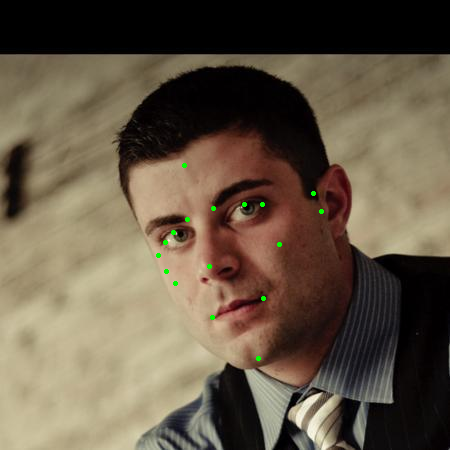

In [18]:
# choosing random image
index = np.random.randint(0, len(x_points))

faceModule = mp.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread(path+'/'+jpg_files[index])
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for idx, landmark in enumerate(face.landmark):
              if idx in landmark_indices:

                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = image.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                  cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

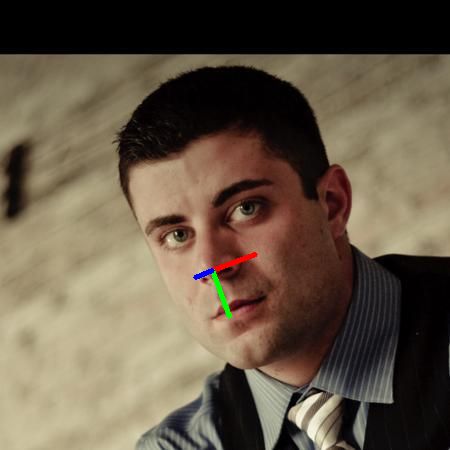

In [19]:
image = cv2.imread(path+'/'+jpg_files[index])
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat(path+'/'+mat_files[index])
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
# Run the face detection on the image
faceModule = mp.solutions.face_mesh
mp_face_detection = mp.solutions.face_detection
face_detection = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.5)
detected_faces = face_detection.process(image)

# Check if any faces were detected
if detected_faces.detections:
    # Loop over the detected faces
    for face in detected_faces.detections:
        # Get the relative keypoints for the face
        keypoints = face.location_data.relative_keypoints
        # Get the x and y position of the nose
        nose_x = int(keypoints[2].x * image.shape[1])
        nose_y = int(keypoints[2].y * image.shape[0])
cv2_imshow(draw_axis(image,pitch,yaw,roll,nose_x,nose_y))

In [20]:
print(index)

11


# Preprocessing

In [21]:
def Normarlize(df):
  normalized_df_X = df.copy()
  for dim in ['x_', 'y_']:

    for feature in [dim+'nose_tip', dim+'chin', dim+'left_corner_of_mouth',dim+ 'right_corner_of_mouth', dim+'left_cheek', 
                    dim+'right_cheek', dim+'left_eyebrow_outer', dim+'right_eyebrow_outer', dim+'left_eye_pupil', dim+'right_eye_pupil',
                    dim+'left_eye_iris', dim+'right_eye_iris', dim+'top_of_head', dim+'left_earlobe', dim+'right_earlobe',dim+ 'left_temple',dim+ 'right_temple']:

        normalized_df_X[feature] = normalized_df_X[feature] - normalized_df_X[dim+'nose_tip']

    diff = normalized_df_X[dim+'top_of_head'] - normalized_df_X[dim+'nose_tip']
 

    for feature in  [dim+'nose_tip', dim+'chin', dim+'left_corner_of_mouth',dim+ 'right_corner_of_mouth', dim+'left_cheek', 
                    dim+'right_cheek', dim+'left_eyebrow_outer', dim+'right_eyebrow_outer', dim+'left_eye_pupil', dim+'right_eye_pupil',
                    dim+'left_eye_iris', dim+'right_eye_iris', dim+'top_of_head', dim+'left_earlobe', dim+'right_earlobe',dim+ 'left_temple',dim+ 'right_temple']:
        normalized_df_X[feature] = normalized_df_X[feature] / diff
  return   normalized_df_X

In [22]:
normalized_df =Normarlize(points_df)
normalized_df.head()

x_nose_tip    x_chin  x_left_corner_of_mouth  x_right_corner_of_mouth  \
0         0.0  0.927350                0.773504                 1.102564   
1         0.0  1.004566                0.917808                 1.050228   
2         0.0  1.014286                0.878571                 1.121429   
3         0.0  1.420765                1.153005                 1.469945   
4         0.0  1.235000                1.025000                 1.320000   

   x_left_cheek  x_right_cheek  x_left_eyebrow_outer  x_right_eyebrow_outer  \
0      0.649573       1.273504              0.888889               1.064103   
1      0.922374       1.196347              0.949772               1.013699   
2      0.764286       1.221429              0.950000               1.064286   
3      0.939891       1.557377              0.983607               1.169399   
4      0.815000       1.430000              0.980000               1.130000   

   x_left_eye_pupil  x_right_eye_pupil  ...  y_right_eyebrow_outer  \
0          0.679487           1.286325  ...               1.511278   
1          0.954338           1.210046  ...               1.211429   
2          0.778571           1.200000  ...               1.085911   
3          0.868852           1.475410  ...               1.210526   
4          0.790000           1.365000  ...               1.358108   

   y_left_eye_pupil  y_right_eye_pupil  y_left_eye_iris  y_right_eye_iris  \
0          1.488722           1.601504         1.458647          1.541353   
1          1.280000           1.291429         1.251429          1.257143   
2          1.106529           1.103093         1.096220          1.096220   
3          1.409357           1.198830         1.356725          1.192982   
4          1.547297           1.378378         1.472973          1.351351   

   y_top_of_head  y_left_earlobe  y_right_earlobe  y_left_temple  \
0            1.0        1.518797         1.676692       1.368421   
1            1.0        1.394286         1.440000       1.314286   
2            1.0        1.137457         1.130584       1.106529   
3            1.0        1.473684         1.169591       1.391813   
4            1.0        1.804054         1.527027       1.668919   

   y_right_temple  
0        1.533835  
1        1.342857  
2        1.103093  
3        1.070175  
4        1.391892  

[5 rows x 34 columns]

In [23]:
labels = pd.DataFrame(labels,columns = ['pitch','yaw','roll'])
labels.head()

pitch       yaw      roll
0 -0.399231  0.018227  0.085676
1  0.470065  1.189533  0.300959
2 -0.184650  0.881137 -0.236852
3 -0.175379  0.299208 -0.373374
4 -0.026812  0.011965 -0.220662

In [24]:
df  = pd.concat([normalized_df,labels], axis=1)
df.shape

(1853, 37)

In [25]:
df_inf = df[df.isin([np.inf, -np.inf]).any(1)]
df_inf


Empty DataFrame
Columns: [x_nose_tip, x_chin, x_left_corner_of_mouth, x_right_corner_of_mouth, x_left_cheek, x_right_cheek, x_left_eyebrow_outer, x_right_eyebrow_outer, x_left_eye_pupil, x_right_eye_pupil, x_left_eye_iris, x_right_eye_iris, x_top_of_head, x_left_earlobe, x_right_earlobe, x_left_temple, x_right_temple, y_nose_tip, y_chin, y_left_corner_of_mouth, y_right_corner_of_mouth, y_left_cheek, y_right_cheek, y_left_eyebrow_outer, y_right_eyebrow_outer, y_left_eye_pupil, y_right_eye_pupil, y_left_eye_iris, y_right_eye_iris, y_top_of_head, y_left_earlobe, y_right_earlobe, y_left_temple, y_right_temple, pitch, yaw, roll]
Index: []

[0 rows x 37 columns]

In [26]:
df.dropna(inplace = True)

# Train Test Split

In [27]:
X = df.drop(columns = ['pitch','yaw','roll'],axis =1 )
X.shape

(1853, 34)

In [28]:
y = df[['pitch','yaw','roll']]
y.shape

(1853, 3)

In [29]:
y_pitch =y['pitch']
y_yaw =y['yaw']
y_roll = y['roll']
y_pitch.shape,y_yaw.shape,y_roll.shape

((1853,), (1853,), (1853,))

In [30]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets for pitch
X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch = train_test_split(X, y_pitch, test_size=0.2, random_state=42)

# Split the data into training and test sets for yaw
X_train_yaw, X_test_yaw, y_train_yaw, y_test_yaw = train_test_split(X, y_yaw, test_size=0.2, random_state=42)

# Split the data into training and test sets for roll
X_train_roll, X_test_roll, y_train_roll, y_test_roll = train_test_split(X, y_roll, test_size=0.2, random_state=42)



# Model

## find_best_regressors

In [31]:

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [32]:


def find_best_regressors(X_train_pitch, y_train_pitch, X_test_pitch, y_test_pitch,
                         X_train_yaw, y_train_yaw, X_test_yaw, y_test_yaw,
                         X_train_roll, y_train_roll, X_test_roll, y_test_roll):
    regressors = [LinearRegression(),
                  KNeighborsRegressor(),
                  SVR(),
                  DecisionTreeRegressor(),
                  RandomForestRegressor(),
                  GradientBoostingRegressor()]

    best_regressors = {}

    # Find the best regressor for pitch data
    for regressor in regressors:
        model = regressor
        model.fit(X_train_pitch, y_train_pitch)
        y_pred = model.predict(X_test_pitch)
        r2 = r2_score(y_test_pitch, y_pred)
        if 'pitch' not in best_regressors or r2 > best_regressors['pitch']['r2']:
            best_regressors['pitch'] = {'model': model,
                                        'r2': r2,
                                        'mse': mean_squared_error(y_test_pitch, y_pred)}

    # Find the best regressor for yaw data
    for regressor in regressors:
        model = regressor
        model.fit(X_train_yaw, y_train_yaw)
        y_pred = model.predict(X_test_yaw)
        r2 = r2_score(y_test_yaw, y_pred)
        if 'yaw' not in best_regressors or r2 > best_regressors['yaw']['r2']:
            best_regressors['yaw'] = {'model': model,
                                      'r2': r2,
                                      'mse': mean_squared_error(y_test_yaw, y_pred)}

    # Find the best regressor for roll data
    for regressor in regressors:
        model = regressor
        model.fit(X_train_roll, y_train_roll)
        y_pred = model.predict(X_test_roll)
        r2 = r2_score(y_test_roll, y_pred)
        if 'roll' not in best_regressors or r2 > best_regressors['roll']['r2']:
            best_regressors['roll'] = {'model': model,
                                       'r2': r2,
                                       'mse': mean_squared_error(y_test_roll, y_pred)}

    return best_regressors


In [ ]:
find_best_regressors(X_train_pitch, y_train_pitch, X_test_pitch, y_test_pitch,
                         X_train_yaw, y_train_yaw, X_test_yaw, y_test_yaw,
                         X_train_roll, y_train_roll, X_test_roll, y_test_roll)

{'pitch': {'model': SVR(),
  'r2': 0.6880765179922885,
  'mse': 0.022766990832269317},
 'yaw': {'model': RandomForestRegressor(),
  'r2': 0.9407763041807742,
  'mse': 0.014990418153985514},
 'roll': {'model': SVR(),
  'r2': 0.8365359439422766,
  'mse': 0.016470604492916423}}

## Functions for different models 

### Random Forest Regressor

In [33]:

def train_random_forest(X_train, X_test, y_train, y_test, n_estimators=100, max_depth=None, max_features='auto'):
    # Initialize the model
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Evaluate the model on test data

    print("test --> Random Forest R2 Score: ", model.score(X_test, y_test))
    print("test --> Random Forest MSE Score: ", mean_squared_error(y_test, model.predict(X_test)))
    
    return model

### Linear Regression

In [34]:
def train_LR(X_train, X_test, y_train, y_test):
    # Initialize the model
    model = LinearRegression()

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Evaluate the model on  test data
    print("test --> LR R2 Score: ", model.score(X_test, y_test))
    print("test --> LR MSE Score: ", mean_squared_error(y_test, model.predict(X_test)))
    
    return model

### SVR

In [45]:

def train_svr(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0, epsilon=0.1):
    # Split the data into training and testing sets
 

    # Initialize the model
    model = SVR(kernel=kernel, C=C, epsilon=epsilon)

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Evaluate the model  on training and test data

    print("test -->SVR R2 Score: ", model.score(X_test, y_test))
    print("test -->SVR MSE Score: ", mean_squared_error(y_test, model.predict(X_test)))
    
    return model



### Gradient Boosting

In [36]:
def train_gradient_boosting(X_train, X_test, y_train, y_test, n_estimators=100, max_depth=3, learning_rate=0.1,min_samples_leaf= 1 ):
    # Initialize the model
    model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,min_samples_leaf=min_samples_leaf)

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Evaluate the model on test data
    print("test --> Gradient Boosting R2 Score: ", model.score(X_test, y_test))
    print("test --> Gradient Boosting MSE Score: ", mean_squared_error(y_test, model.predict(X_test)))
    
    return model

# Train model

- Accoording to the output of best regressor function so 
  - pitch will trained by SVR
  - yaw will be trained by SVR
  - roll will be trained by SVR

## Pitch Model

In [46]:
model_pitch = train_svr(X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch,C = 30 ,epsilon = 0.01)

test -->SVR R2 Score:  0.8195299243224755
test -->SVR MSE Score:  0.01317233486880469


## Yaw Model

In [47]:
model_yaw = train_svr(X_train_yaw, X_test_yaw, y_train_yaw, y_test_yaw,kernel='rbf', C=65, epsilon=0.01)


test -->SVR R2 Score:  0.9667225663375898
test -->SVR MSE Score:  0.008423024581473414


## Roll Model

In [48]:
model_roll = train_svr(X_train_roll, X_test_roll, y_train_roll, y_test_roll,C=15, epsilon=0.001)

test -->SVR R2 Score:  0.8106936808885543
test -->SVR MSE Score:  0.019074465575437596


# Test Models

In [40]:
def extract_landmarks(image_path, landmark_indices):
    faceModule = mp.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        image = cv2.imread(image_path)
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        x_temp = []
        y_temp = []
        if results.multi_face_landmarks != None: 
            for face in results.multi_face_landmarks:
                for index in landmark_indices:
                    landmark = face.landmark[index]
                    x = landmark.x
                    y = landmark.y
                    shape = image.shape
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    x_temp.append(relative_x)
                    y_temp.append(relative_y)
    X= np.hstack((x_temp, y_temp))   
    X = X.reshape(1,len(X))  
    points_df = pd.DataFrame(X,columns=columns)
    nose_x= points_df['x_nose_tip'].iloc[0] 
    nose_y =points_df['y_nose_tip'].iloc[0]
    normalize_df = Normarlize(points_df)
    return nose_x,nose_y,normalize_df



 

234 293


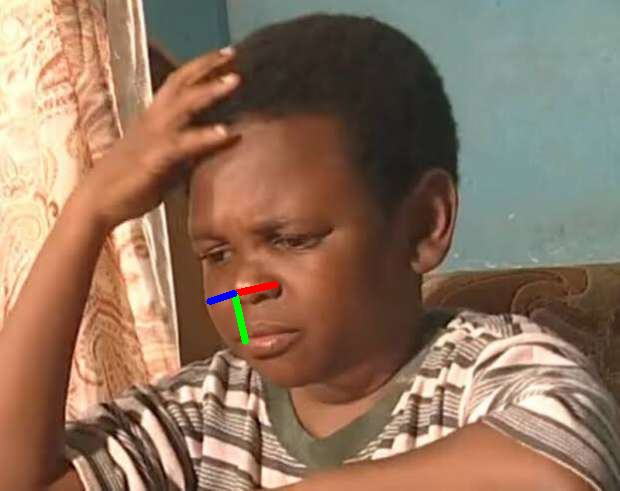

In [ ]:
img = cv2.imread('/content/99.jpg')
nose_x,nose_y,landmarks = extract_landmarks('/content/99.jpg', landmark_indices)
pitch = model_pitch.predict(landmarks)
yaw = model_yaw.predict(landmarks)
roll = model_roll.predict(landmarks)
frame = draw_axis(img,pitch=pitch, yaw=yaw, roll=roll, tdx=nose_x, tdy=nose_y)
cv2_imshow(frame)

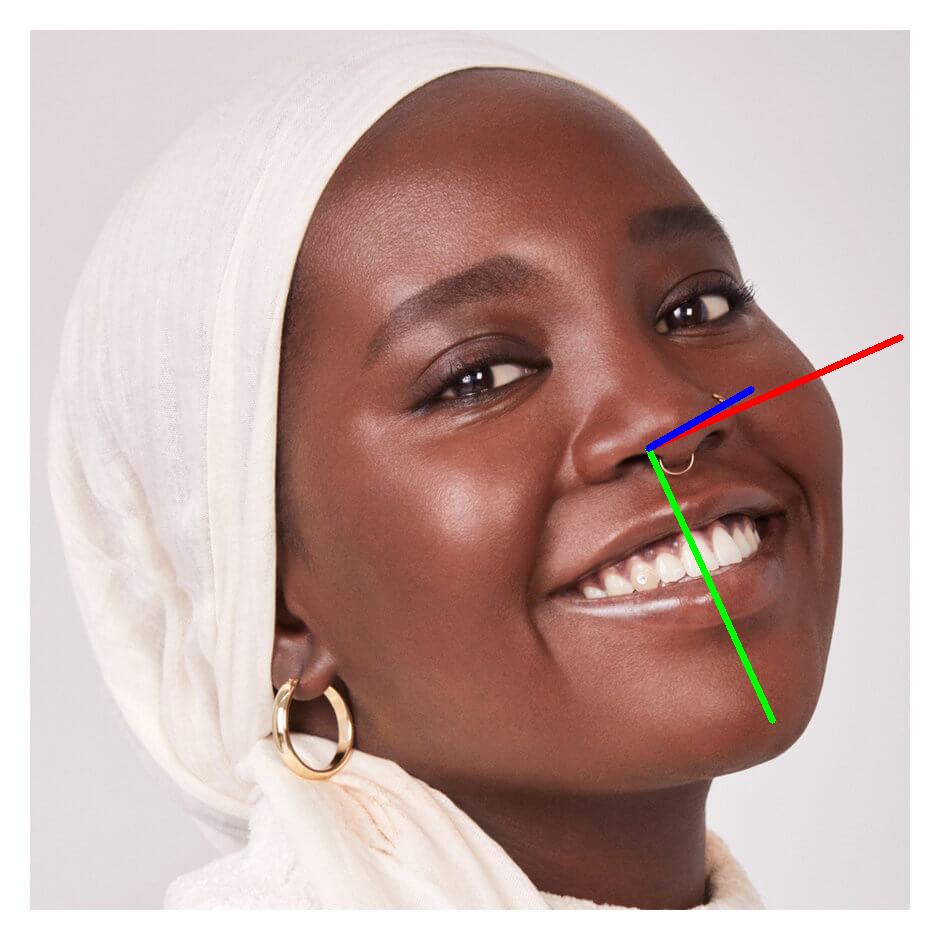

In [ ]:
img = cv2.imread('/content/1.jpg')
nose_x,nose_y ,landmarks = extract_landmarks('/content/1.jpg', landmark_indices)
pitch = model_pitch.predict(landmarks)
yaw = model_yaw.predict(landmarks)
roll = model_roll.predict(landmarks)
frame = draw_axis(img,pitch=pitch, yaw=yaw, roll=roll, tdx=nose_x, tdy=nose_y,size = 300)
cv2_imshow(frame)

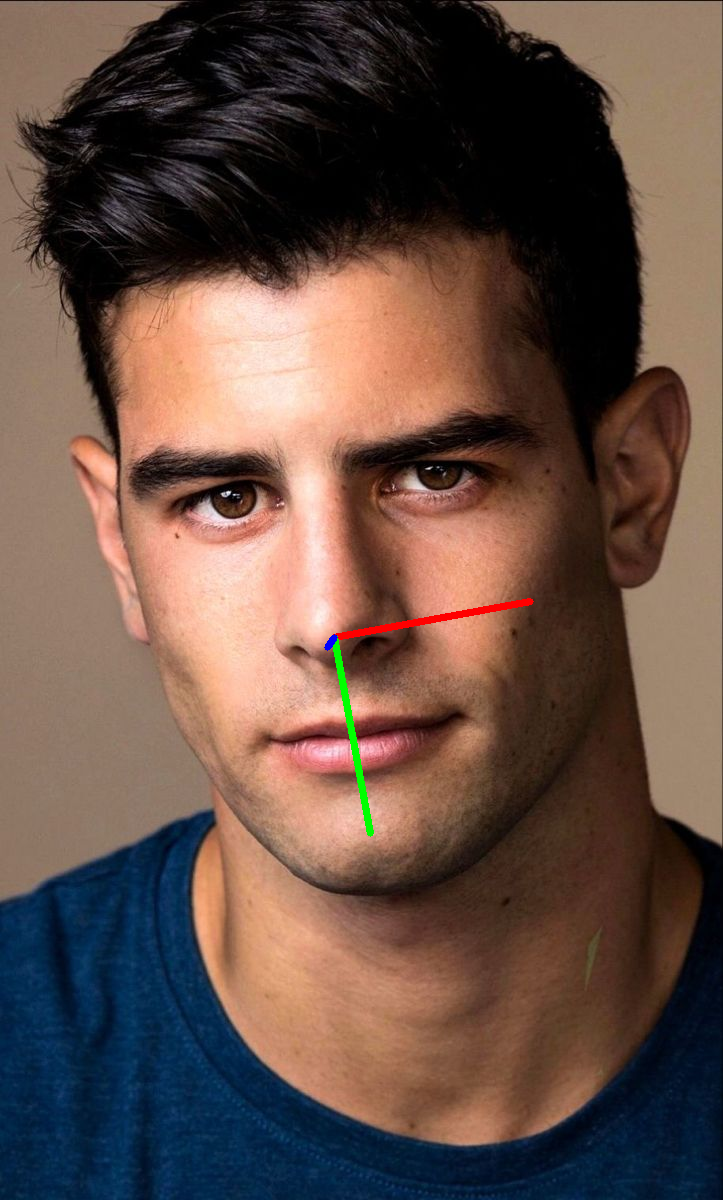

In [ ]:
img = cv2.imread('/content/88.jpg')
nose_x,nose_y ,landmarks = extract_landmarks('/content/88.jpg', landmark_indices)
pitch = model_pitch.predict(landmarks)
yaw = model_yaw.predict(landmarks)
roll = model_roll.predict(landmarks)
frame = draw_axis(img,pitch=pitch, yaw=yaw, roll=roll, tdx=nose_x, tdy=nose_y,size = 200)
cv2_imshow(frame)

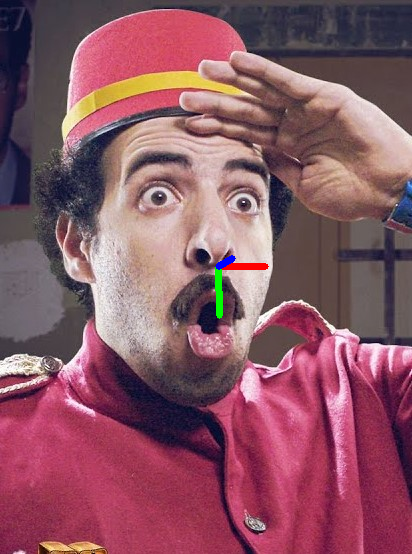

In [ ]:
img = cv2.imread('/content/40.jpg')
nose_x,nose_y ,landmarks = extract_landmarks('/content/40.jpg', landmark_indices)
pitch = model_pitch.predict(landmarks)
yaw = model_yaw.predict(landmarks)
roll = model_roll.predict(landmarks)
frame = draw_axis(img,pitch=pitch, yaw=yaw, roll=roll, tdx=nose_x, tdy=nose_y)
cv2_imshow(frame)

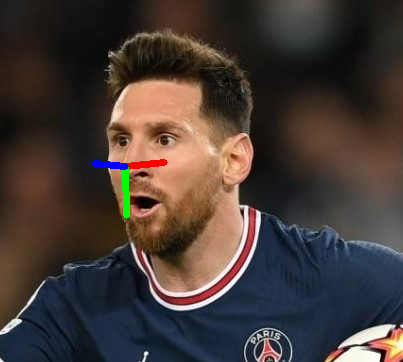

In [ ]:
img = cv2.imread('/content/im.jpg')
nose_x,nose_y ,landmarks = extract_landmarks('/content/im.jpg', landmark_indices)
pitch = model_pitch.predict(landmarks)
yaw = model_yaw.predict(landmarks)
roll = model_roll.predict(landmarks)
frame = draw_axis(img,pitch=pitch, yaw=yaw, roll=roll, tdx=nose_x, tdy=nose_y)
cv2_imshow(frame)

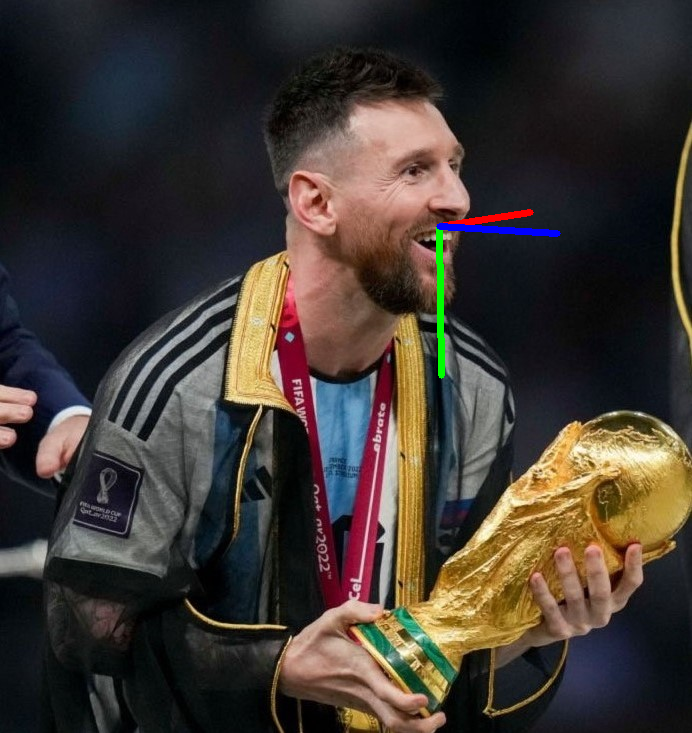

In [ ]:
img = cv2.imread('/content/goat.jpg')
nose_x,nose_y ,landmarks = extract_landmarks('/content/goat.jpg', landmark_indices)
pitch = model_pitch.predict(landmarks)
yaw = model_yaw.predict(landmarks)
roll = model_roll.predict(landmarks)
frame = draw_axis(img,pitch=pitch, yaw=yaw, roll=roll, tdx=nose_x, tdy=nose_y,size = 150 )
cv2_imshow(frame)

# Test on Video

In [42]:
def extract_features_video(image_path, landmark_indices):
    faceModule = mp.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        image =image_path
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        x_temp = []
        y_temp = []

        if results.multi_face_landmarks != None: 
            for face in results.multi_face_landmarks:
                for index in landmark_indices:
                    landmark = face.landmark[index]
                    x = landmark.x
                    y = landmark.y
                    shape = image.shape
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    x_temp.append(relative_x)
                    y_temp.append(relative_y)
        X= np.hstack((x_temp, y_temp))   
        X = X.reshape(1,len(X))  
        points_df = pd.DataFrame(X,columns=columns)
        nose_x= points_df['x_nose_tip'].iloc[0] 
        nose_y =points_df['y_nose_tip'].iloc[0]
        normalize_df = Normarlize(points_df)            
        return nose_x,nose_y,normalize_df


In [43]:
def predict_yaw_pitch_roll_image(model_pitch, model_yaw, model_roll,img):

    # extract the features
    nose_x,nose_y,features = extract_features_video(img,landmark_indices)
 
    # Predict the yaw, pitch, and roll angles
    pitch = model_pitch.predict(features)[0]
    yaw = model_yaw.predict(features)[0]
    roll = model_roll.predict(features)[0]
    # Draw the yaw, pitch, and roll angles on the image
    annotated_image = draw_axis(img, pitch, yaw, roll, nose_x, nose_y, size=100)
    return annotated_image

In [52]:
cap = cv2.VideoCapture('/content/My Recording_5.mp4')
frame_rate = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/content/output.mp4', fourcc, frame_rate, (width, height))

while True:
        try:
        # Read the next frame from the video
            ret, frame = cap.read()
            if not ret:
              break
            frame = cv2.flip(frame,1)
            frame = predict_yaw_pitch_roll_image(model_pitch, model_yaw, model_roll,frame)
            # cv2_imshow(frame)
            out.write(frame)
        except Exception as error:
         print(error)
        
          
  
cap.release()
out.release()